# Playlist Visualizer

Given a Spotify username and a playlist, we utilize Spotify's Web API and the features it collects on every song in its library (over 50 million songs) to create a polar graph visualization of that playlists's relative danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and duration.

This exploration was important in our initial exploration of Spotipy, a Python library that utilizes Spotify's Web API to hit API endpoints that extract data on tracks, artists, albums, and users.

Spotipy Documentation: https://spotipy.readthedocs.io/en/2.12.0/

Spotify Web API Documentation: https://developer.spotify.com/documentation/web-api/

Reference: https://towardsdatascience.com/an-attempt-to-construct-spotify-algorithm-9ac21ae1ecfb

### Import Libraries & Setting Up Spotipy

In [ ]:
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import pprint
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import random
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler

CLIENT_ID = 'a1252d2f88a748328ae048b52770ffb5'
CLIENT_SECRET = 'b57de54acf5740c88028684f1b1a224e'


AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

### Generate list of playlists made by Spotify

In [ ]:
auth_manager = SpotifyClientCredentials('a1252d2f88a748328ae048b52770ffb5', 'b57de54acf5740c88028684f1b1a224e')
sp = spotipy.Spotify(auth_manager=auth_manager)

playlists = sp.user_playlists('spotify')
while playlists:
    # for i, playlist in enumerate(playlists['items']):
        # print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None


### Analyzing Audio Features of an Example Track

In [ ]:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Track ID from the URL
track_id = '7tUSJY4nsDBJTjd1UXKRsT?si=bb7502f51fab4575'

In [ ]:
audio_features = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)

keys = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
modes = {1: 'Major', 0: 'Minor'}

In [ ]:
audio_features.json()

{'danceability': 0.274,
 'energy': 0.144,
 'key': 5,
 'loudness': -14.516,
 'mode': 1,
 'speechiness': 0.0482,
 'acousticness': 0.92,
 'instrumentalness': 0.000388,
 'liveness': 0.29,
 'valence': 0.302,
 'tempo': 61.551,
 'type': 'audio_features',
 'id': '7tUSJY4nsDBJTjd1UXKRsT',
 'uri': 'spotify:track:7tUSJY4nsDBJTjd1UXKRsT',
 'track_href': 'https://api.spotify.com/v1/tracks/7tUSJY4nsDBJTjd1UXKRsT',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7tUSJY4nsDBJTjd1UXKRsT',
 'duration_ms': 195493,
 'time_signature': 5}

### Getting Similar Artists to an Example Artist

In [ ]:
artist_id_ex = '2h93pZq0e7k5yf4dywlkpM' # Frank Ocean

similar_artists = requests.get(BASE_URL + 'artists/' + artist_id_ex + '/related-artists', headers=headers)

similar_artists.json()

{'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/73sIBHcqh3Z3NyqHKZ7FOL'},
   'followers': {'href': None, 'total': 9184649},
   'genres': ['atl hip hop', 'hip hop', 'rap'],
   'href': 'https://api.spotify.com/v1/artists/73sIBHcqh3Z3NyqHKZ7FOL',
   'id': '73sIBHcqh3Z3NyqHKZ7FOL',
   'images': [{'height': 640,
     'url': 'https://i.scdn.co/image/ab6761610000e5eb3ef779aa0d271adb2b6a3ded',
     'width': 640},
    {'height': 320,
     'url': 'https://i.scdn.co/image/ab676161000051743ef779aa0d271adb2b6a3ded',
     'width': 320},
    {'height': 160,
     'url': 'https://i.scdn.co/image/ab6761610000f1783ef779aa0d271adb2b6a3ded',
     'width': 160}],
   'name': 'Childish Gambino',
   'popularity': 82,
   'type': 'artist',
   'uri': 'spotify:artist:73sIBHcqh3Z3NyqHKZ7FOL'},
  {'external_urls': {'spotify': 'https://open.spotify.com/artist/4V8LLVI7PbaPR0K2TGSxFF'},
   'followers': {'href': None, 'total': 8591972},
   'genres': ['hip hop', 'rap'],
   'href': 'https://api

In [ ]:
client_credentials_manager = SpotifyClientCredentials(CLIENT_ID, CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlist_id= '5OcRpg8E6cVQ9VeHuBZ9BL?si=636367dc33614a00'
results = sp.playlist(playlist_id)

pp = pprint.PrettyPrinter(indent=1)

### Function: takes a Spotify Username and Generates a list of Playlists and their IDs

In [ ]:
'''getPlaulists uses the GET USERS PLAYLISTS endpoint of the Spotify Web API to retrieve a user's public playlists on spotify, 
complete with all of their songs and information about each song'''

def getPlaylists(username):

    user = sp.user(username)

    user_playlists = sp.user_playlists(username, limit=50, offset=0)

    ids = []

    pp = pprint.PrettyPrinter(indent=1)

    num_playlists = len(user_playlists['items'])

    for i in range(num_playlists):
        ids.append((user_playlists['items'][i]['id'], user_playlists['items'][i]['name']))

    # print(num_playlists)
    # pp.pprint(user_playlists['items'][0])
    return ids

    # print(sp.user_playlists('cat._.h', limit=50, offset=0))
    # use current_user_recently_played(limit=50, after=None, before=None)

    playlist_num = random.choice(range(num_playlists))

    playlist_id = ids[playlist_num]
    playlist_name = user_playlists['items'][playlist_num]['name']
    # print(playlist_num, playlist_id, playlist_name)

getPlaylists('atnick484')

[('05GJRtlCpvnuHoY9JncjsV', 'soa whrb 4/15'),
 ('0k1eMX0mNHv593o2zug4J4', 'HRO: perc ens (spring 2021)'),
 ('6ZeR1ij9EwbIrejhO88XOR', 'HRO Cycle 3 | February 2022'),
 ('1HSOZKFK59QAVJaw9eitgA', 'gravy'),
 ('46xDDDqzxrDqIdrQCKx1PX', 'lift'),
 ('0KIZzXiuCTzOjtoM9tmw4n', 'Sick maya'),
 ('3jnCpvbh29QmLFuln6fANT', 'orgy (a term from WHRB)'),
 ('6HDGoqUVIoEL5SPKmLAUGa', 'class'),
 ('4m36zW8ocklAB7sDSbCKOZ', 'maori reggae'),
 ('21yR3SdSB2QzwMtG9uDtNX', 'windy and sunny'),
 ('5jn1B19mgQpfxtd3G88ECP', '11/21 DYWALM?'),
 ('17nDS5OMKdQmrvkojz37sm', '11/7 DYWALM?'),
 ('47FcnxYuUIxQ6JOgkZSvee', '10/3 DYWALM?'),
 ('508VnUcCYJPu4cYzVIGzYA', 'some favorites'),
 ('5NmOWk8XOFbyGTc8QfIJ2M', '3.26.21 [boston week!]'),
 ('4yJmY1Kva6BWwzI0iGRKDj', '11.5.21 | friday five jazz'),
 ('0odBZtIue9WbPHDTQhYKh9', '10.29.21 | friday five jazz'),
 ('3ClEVJUBoxphf7GCh0YmNs', '10.22.21 | friday five jazz'),
 ('0rvlQWPZ8sW45pWzawTRYp', '10.8.21 | friday five jazz'),
 ('30IDhVACTMZSuznpp4d5cI', '9.30.21 | friday five jaz

### Function: takes a playlist ID and plots a polar graph of mean audio features for that playlist

In [ ]:
'''analyze_playlist extracts information about each song in the playlist, taking the mean of the data for each audio 
feature, and graphing it using the matplotlib visualization package'''

def analyze_playlist(playlist_id):

    results = sp.playlist(playlist_id)

    song_ids = []

    for item in results['tracks']['items']:
            track = item['track']['id']
            song_ids.append(track)
        
    song_meta={'id':[],'album':[], 'name':[], 
            'artist':[],'explicit':[],'popularity':[]}

    for song_id in song_ids:
        # get song's meta data
        meta = sp.track(song_id)
        
        # song id
        song_meta['id'].append(song_id)

        # album name
        album=meta['album']['name']
        song_meta['album']+=[album]

        # song name
        song=meta['name']
        song_meta['name']+=[song]
        
        # artists name
        s = ', '
        artist=s.join([singer_name['name'] for singer_name in meta['artists']])
        song_meta['artist']+=[artist]
        
        # explicit: lyrics could be considered offensive or unsuitable for children
        explicit=meta['explicit']
        song_meta['explicit'].append(explicit)
        
        # song popularity
        popularity=meta['popularity']
        song_meta['popularity'].append(popularity)

    song_meta_df=pd.DataFrame.from_dict(song_meta)

    # check the song feature
    features = sp.audio_features(song_meta['id'])
    # change dictionary to dataframe
    features_df=pd.DataFrame.from_dict(features)

    # convert milliseconds to mins
    # duration_ms: The duration of the track in milliseconds.
    # 1 minute = 60 seconds = 60 × 1000 milliseconds = 60,000 ms
    features_df['duration_ms']=features_df['duration_ms']/60000

    # combine two dataframe
    final_df=song_meta_df.merge(features_df)


    music_feature = features_df[['danceability', 'energy', 'loudness', 'speechiness', 
        'acousticness', 'instrumentalness', 'liveness',
        'valence', 'tempo', 'duration_ms']]

    min_max_scaler = MinMaxScaler()
    music_feature.loc[:]=min_max_scaler.fit_transform(music_feature.loc[:])

    # plot size
    fig=plt.figure(figsize=(12,8))

    # convert column names into a list
    categories=list(music_feature.columns)
    # number of categories
    N=len(categories)

    # create a list with the average of all features
    value=list(music_feature.mean())

    # repeat first value to close the circle
    # the plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    value+=value[:1]
    # calculate angle for each category
    angles=[n/float(N)*2*math.pi for n in range(N)]
    angles+=angles[:1]

    # plot
    plt.polar(angles, value)
    plt.fill(angles,value,alpha=0.3,color='#f540a0')

    # plt.title('Discovery Weekly Songs Audio Features', size=35)

    plt.xticks(angles[:-1],categories, size=15)
    plt.yticks(color='grey',size=15)
    plt.show()
                    

### User Interfact to Analyze their Playlist
A user can run this cell to input their username and a playlist they want to analyze.

0  | soa whrb 4/15
1  | HRO: perc ens (spring 2021)
2  | HRO Cycle 3 | February 2022
3  | gravy
4  | lift
5  | Sick maya
6  | orgy (a term from WHRB)
7  | class
8  | maori reggae
9  | windy and sunny
10 | 11/21 DYWALM?
11 | 11/7 DYWALM?
12 | 10/3 DYWALM?
13 | some favorites
14 | 3.26.21 [boston week!]
15 | 11.5.21 | friday five jazz
16 | 10.29.21 | friday five jazz
17 | 10.22.21 | friday five jazz
18 | 10.8.21 | friday five jazz
19 | 9.30.21 | friday five jazz
20 | 9.23.21 | friday five jazz
21 | 9.17.21 | friday five jazz
22 | 4.29.21
23 | 4.22.21 [piano]
24 | 4.15.21 [vibraphonists]
25 | 4.8.21 
26 | 4.1.21 [french jazz]
27 | 3.25.21 [boston week!]
28 | [discarded 3.17.21]
29 | 3.18.21
30 | 3.11.21
31 | 3.4.21 [modernish]
32 | 2.25.21 [early black vocalists]
33 | 2.11.21 [upeat]
34 | My Playlist #44
35 | random r&b
36 | call me
37 | are and be
38 | a la playa
39 | shredding the gnar
40 | adj. all the rage
41 | april 
42 | Dopamine
43 | harvard radcliffe orchestra fall '20
44 | vibe
4

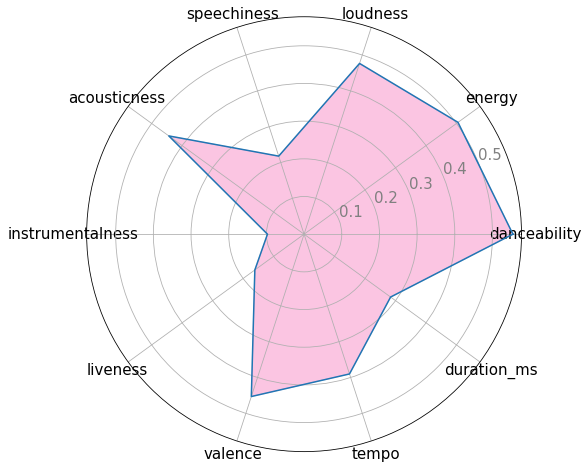


You have chosen to visualize are and be

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


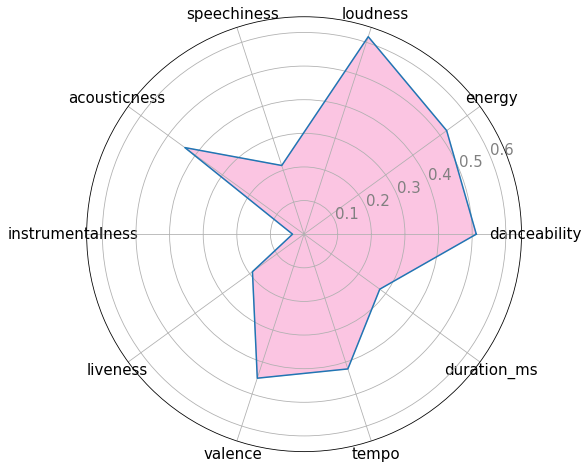

KeyboardInterrupt: Interrupted by user

In [ ]:
'''This code generates input prompts for the user, taking their username and asking for them to select one of their playlists. 
Once a playlist is selected, its mean audio features are visualized'''
username = input("Enter a Spotify username")
count = 0
playlists = getPlaylists(username)
for playlist in playlists:
    if count > 9:
        print(str(count) + ' | ' + playlist[1])
    else:
        print(str(count) + '  | ' + playlist[1])
    count += 1

val = int(input("Enter the number next to the playlist you want to visualize"))
while val >= 0:
    playlist = playlists[val]
    print()
    print('You have chosen to visualize ' + playlist[1])
    print()
    analyze_playlist(playlist[0])
    val = int(input("Enter another number to visualize another playlist, or enter -1 to quit"))

### Auxillary Code (unrelated): takes a playlist ID and creates a CSV file with track names, artists, release dates, and duration
Used for Andrew's radio show planning.

In [ ]:
'''Makes a CSV from a playlist (used for something unrelated to this class, Andrew's radio show). Still nice to have in here'''

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# connecting with spotify api
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID,client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

# giving playlist link
playlist_code = input("Enter the Playlist ID: \n")
playlist_dict = sp.playlist(playlist_code)

no_of_songs = playlist_dict["tracks"]["total"]

album_list = []
song_list = []
release_date_list = []
artists_list = []
duration_list = []

tracks = playlist_dict["tracks"]
items = tracks["items"]
offset=0
i=0
while i<no_of_songs:
    millis = items[i-offset]["track"]["duration_ms"]
    millis = int(millis)
    seconds=(millis/1000)%60
    seconds = int(seconds)
    minutes=(millis/(1000*60))%60
    minutes = int(minutes)
    hours=(millis/(1000*60*60))%24
    if seconds > 9:
        if minutes > 9:
            duration = '00:' + str(minutes) + ':' + str(seconds)
        else:
            duration = '00:0' + str(minutes) + ':' + str(seconds)
    else:
        if minutes > 9:
            duration = '00:' + str(minutes) + ':0' + str(seconds)
        else:
            duration = '00:0' + str(minutes) + ':0' + str(seconds)
    song = items[i-offset]["track"]["name"]
    album = items[i-offset]["track"]["album"]["name"]
    release_date = items[i-offset]["track"]["album"]["release_date"]
    artists = [k["name"] for k in items[i-offset]["track"]["artists"]]
    artists = ','.join(artists)
    album_list.append(album)
    song_list.append(song)
    release_date_list.append(release_date)
    artists_list.append(artists)
    duration_list.append(duration)
    if (i+1)%100 == 0:
        tracks = sp.next(tracks)
        items = tracks["items"]
        offset = i+1
    i+=1
    
final_data = list(zip(song_list,artists_list,album_list,release_date_list, duration_list))


# creating csv file
import csv
Details = ["Name","Artists","Album","Release Date", "Duration"]
rows = final_data
with open("songs.csv",'w', newline='') as f:
    write = csv.writer(f)
    write.writerow(Details)
    write.writerows(rows)

f.close()

'''

KeyboardInterrupt: Interrupted by user

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=69771c6e-a76e-4b75-8043-409b087b6b70' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>